In [1]:
from lcode2dPy.simulation.interface import Simulation
from lcode2dPy.diagnostics.targets import BeamDiagnostics
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam_generator.beam_generator2 import make_beam, Gauss, rGauss
from lcode2dPy.beam_generator.beam_generator import make_beam as make_beam2
from lcode2dPy.beam_generator.beam_profiles import SmoothDistr, StepwiseXiDistr
from scipy.stats import norm, weibull_min
import numpy as np
import matplotlib.pyplot as plt
import subprocess

## Old beam generator

In [2]:
# Config
config = default_config
config.set('time-step', 1000)
config.set('time-limit', 20000.5)
config.set('window-length', 15)
config.set('window-width', 3)
config.set('r-step', 0.05)
config.set('xi-step', 0.05)

# Beam
gamma = 426
angspread = 1e-5
m_proton = 958/0.51

beam_pars = dict(xi_distr=Gauss(sigma=100, vmin=-config.getfloat('window-length'), vmax=0),
                 r_distr=rGauss(vmin=0, vmax=config.getfloat('window-width')),
                 ang_distr=Gauss(sigma=angspread, vmin=None, vmax=None),
                 pz_distr=Gauss(gamma*m_proton, gamma*m_proton *
                                1e-4, vmin=None, vmax=None),
                 Ipeak_kA=2*40/1000,
                 q_m=1/m_proton,
                 saveto=None)

# Diagnostics
diagnostics = [
    BeamDiagnostics(config=config, period=20000)
]

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config)
beam1 = make_beam(config, **beam_pars)

Number of particles: 119551
Number of particles in the middle layer: 200


## New beam generator

In [3]:
# Config
config = default_config
config.set('time-step', 1000)
config.set('time-limit', 20000.5)
config.set('window-length', 15)
config.set('window-width', 3)
config.set('r-step', 0.05)
config.set('xi-step', 0.05)
window_width = config.getfloat('window-width')
# Beam
center = 0
L = np.sqrt(2 * np.pi) * 6 / 0.02
sigma = 1
gamma = 426
energy_spread = 3e-4
angular_spread = 1e-5
m_proton = 958/0.51
amp = 80 / 17e3 # 80 A
cosine = lambda x: 1/2 * (1 + np.cos(2 * np.pi * (x - center) / L))

beam_distrs = dict(xi = StepwiseXiDistr(cosine, 0, -L/2, L/2, amp=amp),
                   r = SmoothDistr(weibull_min, 0, window_width, 2, 0, sigma),
                   p_z = SmoothDistr(norm, None, None, gamma*m_proton, energy_spread),
                   p_r = SmoothDistr(norm, None, None, 0, gamma*m_proton*angular_spread),
                   M = SmoothDistr(norm, None, None, 0, gamma*m_proton*angular_spread)
)

beam_pars = dict(distrs=beam_distrs,
                 q_m=1/m_proton,
                 partic_in_layer=400)

# Diagnostics
diagnostics = [
    BeamDiagnostics(config=config, period=20000)
]

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config, beam_generator=make_beam2)
beam2 = make_beam2(config, **beam_pars)

## SSM simulation

In [4]:
sim.step(int(config.getfloat('time-limit') // config.getfloat('time-step')))

In [5]:
time_limit = config.getfloat('time-limit')
time_step = config.getfloat('time-step')
data = diagnostics[0].data
t = list(data.keys())[-1]
beam = diagnostics[0].data[t]

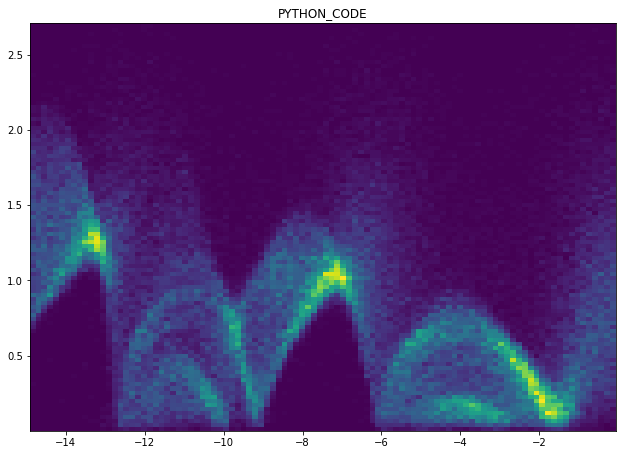

In [6]:
bins = 100
py_hist = plt.hist2d(beam['xi'], beam['r'], bins=bins)[0]
plt.title('PYTHON_CODE')

fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
plt.plot();

## Beam comparison

In [ ]:
par = 7
plt.hist(beam1.T[par][:-1], 100, alpha=0.5);
plt.hist(beam2.T[par][:-1], 100, alpha=0.5, color='C1');

In [ ]:
beam1.T[par][:-1][3], beam2.T[par][3]